## Text Classification ##

This notebook is based on this Pytorch tutorial: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial
        
In this notebook, we will train a network to learn how to classify the country of a name. In this example, we will tokenize per character rather than per word

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [ ]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

57
Slusarski


In [ ]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories) # Classes
# print(category_lines)

[]
0


In [ ]:
print(category_lines['Japanese'][:5])

KeyError: ignored

### Make everything into one-hot vector ###

For it to be used (transform into a tensor)

In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#         print(x.shape)
        # output, hidden= self.rnn(x,hidden)
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#         print(hidden.shape)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [ ]:
x = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()

output, next_hidden = rnn(x, hidden)
print(output.argmax(-1))
print(output.topk(3).indices)

In [ ]:
x = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
print(output.argmax(-1))

## Preparing for training! ##

In [ ]:
# Helper function to get the actual category from the best

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

### Quick way to get training example (Src = Name, Trg = Language) ###

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


## Train now!!! ##

In [ ]:
def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train with the RNN from scrath ####

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results with a confusion matrix! ##

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 20000

# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor, model_basic)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Now we can try predicting our own things! ##

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Nero')
predict('Vivek')

### So now lets shift to using the RNN Module from Pytorch ###

In [ ]:
def categoryToTensor(category):
#     tensor = torch.zeros([1, 1], dtype=torch.long)
#     tensor[0][0] = all_categories.index(category)
    tensor = torch.zeros([1, len(all_categories)], dtype=torch.long)
    tensor[0][all_categories.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
#     print(category_tensor.shape)

In [ ]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

In [ ]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)
    
#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

#### Train from the RNN using pytorch approach ####

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

In [ ]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Vivek')
predict('Nero')

## Now one of your assigments is to adapt/expand this text classifier! ##

- Adapt the task to another similar task
- Use LSTMs or GRU to compare with both Vanilla RNN approaches

You can keep it at character-level or you can extend it to word-level (the vocabulary will change)

Try with different datasets with a similar Input/Output system:
- Book or character name -> writer
- Game's titles -> company or genre
- Any word -> language
- Whatever you can think it can be classified

## Classification of true and fake news using LSTM 

In [ ]:
import pandas as pd
import string
import torch

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training
import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


##Reading data from google drive

*   The data of fake news and true news is downloaded from kaggle in the form of two separate csv files.
*   Later the datasets are imported in google drive to be mounted on colab



In [ ]:
true = pd.read_csv('/gdrive/MyDrive/True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake = pd.read_csv('/gdrive/MyDrive/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


The raw datasets have field such as title of the news,text written in the news ,subject along with date the news was published.

Now the two separate csv files are joined after the true and fake news are allocated labels ;1 for true and 0 for fake

In [ ]:
true['truth'] = 1
fake['truth'] = 0
df = pd.concat([true, fake], axis=0, ignore_index=True)
df.shape
df.head()

,title,text,subject,date,truth
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


##Preprocessing and Splitting the dataset into training,validation and testing sub-parts

*   In the preprocessing part, the rows with missing values are deleted. Also,text strings are trimmed to a specified word limit.Trimming the samples in a dataset is not necessary but with trimmed dataset,training is faster for heavier models and is normally enough to predict the outcome.
*Later, the only the features of title of the news and text of the news along with label are kept. Rest are eliminated.
*  A new feature joining title and text is created which has string sfrom both the columns to remove the space between both.



In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.10
train_valid_ratio = 0.80
# Drop rows with empty text
df.drop( df[df.text.str.len() < 5].index, inplace=True)
first_n_words = 200
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x
df['titletext'] = df['title'] + ". " + df['text']
df= df.reindex(columns=['truth', 'title', 'text', 'titletext'])
# Trim text and titletext to first_n_words
df['text'] = df['text'].apply(trim_string)
df['titletext'] = df['titletext'].apply(trim_string) 
# Split according to label
df_real = df[df['truth'] == 0]
df_fake = df[df['truth'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)



This is how the datsets look after preprocessing.

In [ ]:
df_train.head()

,truth,title,text,titletext
0,0,Sarah Silverman’s Hysterical Video For Bernie...,"On Monday, Sarah Silverman released a hilariou...",Sarah Silverman’s Hysterical Video For Bernie ...
1,0,Perfect Match? Evidence Leans Towards Sarah P...,Donald Trump set tongues wagging with a tweet ...,Perfect Match? Evidence Leans Towards Sarah Pa...
2,0,NOT NEWS: [Graphic Video] Michigan Woman Runs ...,This is a story that will never make the news....,NOT NEWS: [Graphic Video] Michigan Woman Runs ...
3,0,HEROIC Muslim Student Helps Track Down Man Wh...,The situation that 17-year old Ahmed Khalifa s...,HEROIC Muslim Student Helps Track Down Man Who...
4,0,REVEALED: Trump Illegally Violated Embargo Ag...,The law and order candidate broke the law agai...,REVEALED: Trump Illegally Violated Embargo Aga...


##saving datasets in separate csv files 

In [ ]:
destination_folder = '/gdrive/MyDrive/'
# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [ ]:
 print(torch.__version__)

1.10.0+cu111


## Further preprocessing, batchifying and creating vocabulary

Torchtext.data provides the ability to adapt or change the dataset.Like Field part allows to describe a a feature with particular instructions to convert to tensor , and Dataset defines columns stored in CSV, TSV, or JSON format.BucketIterator defines an iterator that batches examples of similar lengths together.

In [ ]:
!pip install -U torchtext==0.11.0
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator




*   With Field text data is further preprocessed. Text field strings are tokenized in sequential examples with spacy , and the text is changed to lowercase with lower=true

*  With batch_first True, tensors with the batch dimension first are produced.
* With include_lengths, tuples of padded minibatch is returned. 
*  Then with Tabulardataset datasets of training,testing and validating datset are created but with removed first line i.e. without headers.
* Bucketiterator batches the examples of equal length in each of the 3 datasets with batch size =32. Sorting examples within the batch and the dataset is true.
*The train, valid, and test iterators are created that load the data.
*With build_vocab, vocabulary is created from training dataset with minimum frequency for a token to be part of vocab is 3.



In [ ]:

source_folder = '/gdrive/MyDrive'
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('truth', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

## Defining LSTM Model for classification task

LSTM class is defined that inherits from the nn.Module. Inside the LSTM, we construct an Embedding layer, followed by a bi-LSTM layer, and ending with a fully connected linear layer. In the forward function, we pass the text IDs through the embedding layer to get the embeddings, pass it through the LSTM accommodating variable-length sequences, learn from both directions, pass it through the fully connected linear layer, and finally sigmoid to get the probability of the sequences belonging to FAKE.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

Before training, save and load functions are built for checkpoints and metrics. For checkpoints, the model parameters and optimizer are saved; for metrics, the train loss, valid loss, and global steps are saved so diagrams can be easily reconstructed later.

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## Defining training function

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(), # binary cross entropy loss
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,           # these are default epochs
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in train_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                      labels = labels.to(device)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

## Training the model

The LSTM model is trained with 10 epochs and save the checkpoint and metrics whenever a hyperparameter setting achieves the best (lowest) validation loss. Apart from that, learning rate is small with the value 0.001 and optimizer chosen is Adam.

In [ ]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [55/1110], Train Loss: 0.5173, Valid Loss: 0.3484
Model saved to ==> /gdrive/MyDrive//model.pt
Model saved to ==> /gdrive/MyDrive//metrics.pt
Epoch [1/10], Step [110/1110], Train Loss: 0.1419, Valid Loss: 0.0403
Model saved to ==> /gdrive/MyDrive//model.pt
Model saved to ==> /gdrive/MyDrive//metrics.pt
Epoch [2/10], Step [165/1110], Train Loss: 0.0352, Valid Loss: 0.0424
Epoch [2/10], Step [220/1110], Train Loss: 0.0495, Valid Loss: 0.0288
Model saved to ==> /gdrive/MyDrive//model.pt
Model saved to ==> /gdrive/MyDrive//metrics.pt
Epoch [3/10], Step [275/1110], Train Loss: 0.0156, Valid Loss: 0.0228
Model saved to ==> /gdrive/MyDrive//model.pt
Model saved to ==> /gdrive/MyDrive//metrics.pt
Epoch [3/10], Step [330/1110], Train Loss: 0.0138, Valid Loss: 0.0151
Model saved to ==> /gdrive/MyDrive//model.pt
Model saved to ==> /gdrive/MyDrive//metrics.pt
Epoch [4/10], Step [385/1110], Train Loss: 0.0038, Valid Loss: 0.0188
Epoch [4/10], Step [440/1110], Train Loss: 0.0047, 

## Plotting training vs validation loss

Model loaded from <== /gdrive/MyDrive//metrics.pt


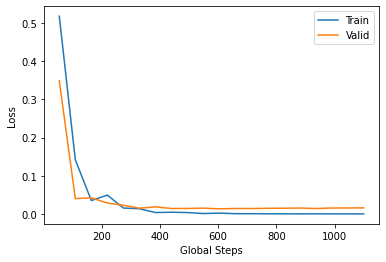

In [ ]:
import matplotlib.pyplot as plt
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

The graph shows both the training and validation error have followed similar trajectory and are almost nil after the first few iterations. The model is well trained.

## Defining evaluation function

In [ ]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in test_loader:           
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Model loaded from <== /gdrive/MyDrive//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9992    0.9961    0.9976     19275
           0     0.9964    0.9992    0.9978     20566

    accuracy                         0.9977     39841
   macro avg     0.9978    0.9977    0.9977     39841
weighted avg     0.9977    0.9977    0.9977     39841



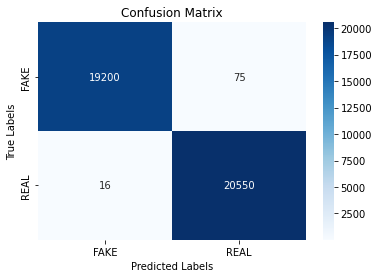

In [ ]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Finally for evaluation, the best model is picked previously saved and evaluate it against the test dataset. I use a default threshold of 0.5 to decide when to classify a sample as FAKE. If the model output is greater than 0.5, news is classified as FAKE; otherwise, REAL. The output of the classification report indicating the precision, recall, and F1-score for each class, as well as the overall accuracy. The one layer biLSTM model gives the accuracy of 99% when tested on test dataset.